In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
filepath = 'https://raw.githubusercontent.com/S1mDu/DataScienceMachineLearning/refs/heads/main/Data/Cantonal/'

# Cantonal Data Analysis

## Merging the databases

In [3]:
df_pop = pd.read_csv(filepath + 'population.csv')
df_climate = pd.read_csv(filepath + 'climate_df.csv', sep=';')
df_gdp = pd.read_csv(filepath + 'final_GDP.csv')
df_pm10 = pd.read_csv(filepath + 'PM10.csv')

In [4]:
df_pm10.rename(columns={'Value': 'pollution'}, inplace=True)
df_gdp.rename(columns={'date': 'year'}, inplace=True)
df_pop.drop(columns=['canton'], inplace=True)
df_gdp.drop(columns=['canton'], inplace=True)
df_pm10.drop(columns=['Samplingpoint', 'Canton'], inplace=True)

In [5]:
final_df = pd.merge(df_gdp,df_pop, on=['Name', 'year',], how='left')
final_df = pd.merge(final_df,df_pm10, on=['Name', 'year',], how='left')
final_df = pd.merge(final_df,df_climate, on=['Name', 'year',], how='left')
final_df.Name.unique()

array(['BE_Bern_urban', 'BL_BaselBinningen_suburban', 'BS_Basel_urban',
       'GE_Meyrin_suburban', 'LU_Rigi_rural', 'NE_Chaumont_rural',
       'TG_Taenikon_rural', 'TI_Lugano_urban', 'VD_Lausanne_urban',
       'VS_Saxon_rural', 'ZH_Zuerich_urban'], dtype=object)

In [6]:
final_df.sort_values(by=['year', 'Name'], inplace=True)

In [7]:
# Missing values for Basel stadt so we use the values from Basel Binningen due to the proximity of the two locations
final_df.loc[final_df['Name'] == 'BS_Basel_urban', 'temp'] = final_df.loc[final_df['Name'] == 'BL_BaselBinningen_suburban', 'temp'].values
final_df.loc[final_df['Name'] == 'BS_Basel_urban', 'precip'] = final_df.loc[final_df['Name'] == 'BL_BaselBinningen_suburban', 'precip'].values

In [8]:
vhc = pd.read_csv(filepath + 'Final_vhc.csv', index_col=0)

In [9]:
vhc.drop(columns=['pop', 'pollution', 'temp', 'precip', 'GDP'], inplace=True)

In [10]:
data = pd.merge(final_df, vhc, how='left', on=['Name', 'year'])

In [11]:
data.rename(columns={"% EV vs Fossil":"EVshare", 'Electricity':'EV', 'Fossil': 'ICE'}, inplace=True)

In [12]:
df = data.copy()

## Dealing with last missing values

In [13]:
# Replace missing pollution values in 2015 with the mean of 2014 and 2016 for the same canton
def fill_missing_pollution(df):
    for canton in df['Canton'].unique():
        mask_2015 = (df['year'] == 2015) & (df['Canton'] == canton)
        mask_2014 = (df['year'] == 2014) & (df['Canton'] == canton)
        mask_2016 = (df['year'] == 2016) & (df['Canton'] == canton)
        
        if mask_2015.any():
            mean_pollution = df.loc[mask_2014, 'pollution'].mean() + df.loc[mask_2016, 'pollution'].mean()
            mean_pollution /= 2
            df.loc[mask_2015, 'pollution'] = df.loc[mask_2015, 'pollution'].fillna(mean_pollution)

fill_missing_pollution(df)

In [14]:
# Replace missing pollution values in 2015 with the mean of 2014 and 2016 for the same canton
def fill_missing_pollution(df):
    for canton in df['Canton'].unique():
        mask_2017 = (df['year'] == 2017) & (df['Canton'] == canton)
        mask_2016 = (df['year'] == 2014) & (df['Canton'] == canton)
        mask_2018 = (df['year'] == 2018) & (df['Canton'] == canton)
        
        if mask_2017.any():
            mean_pollution = df.loc[mask_2016, 'pollution'].mean() + df.loc[mask_2018, 'pollution'].mean()
            mean_pollution /= 2
            df.loc[mask_2017, 'pollution'] = df.loc[mask_2017, 'pollution'].fillna(mean_pollution)

fill_missing_pollution(df)

In [15]:
dict_cfullname = {
    'GE':'Genève',
    'TG':'Thurgau',
    'VS':'Valais',
    'AG':'Aargau', 
    'SZ':'Schwyz',
    'ZH':'Zürich',
    'OW':'Obwalden',
    'FR':'Fribourg',
    'GL':'Glarus',
    'UR':'Uri',
    'NW':'Nidwalden',
    'SO':'Solothurn',
    'AE':'Appenzell Ausserrhoden',
    'JU':'Jura',
    'GR':'Graubünden',
    'VD':'Vaud',
    'LU':'Luzern',
    'TI':'Ticino',
    'ZG':'Zug',
    'BL':'Basel-Landschaft',
    'SG':'St. Gallen',
    'SH':'Schaffhausen',
    'BE':'Bern',
    'BS':'Basel-Stadt',
    'NE':'Neuchâtel',
    'AI':'Appenzell Innerrhoden'
}

In [16]:
df['CantFName'] = df['Canton'].map(dict_cfullname)

## Swiss map with cantons

As we need to load the file in local in order to run it. The Swiss map section is commented. Please download the swissmap assets in Github to generate it.

In [17]:
'''# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)
switzerland_map = gpd.read_file(filepath + 'swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')

# List of cantons you have data for
cantons_with_data = df['CantFName'].unique()'''

"# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)\nswitzerland_map = gpd.read_file(filepath + 'swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')\n\n# List of cantons you have data for\ncantons_with_data = df['CantFName'].unique()"

In [18]:
'''# Highlight the cantons
switzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
switzerland_map.plot(ax=ax, color='white', edgecolor='black')
switzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')
ax.axis('off')  # Hide the axis
# Add legend and title
#plt.legend()
#plt.title('Available Cantons')
plt.savefig(perso_filepath + 'available_cantons.png', transparent=True)  # Save with transparent background
plt.show()'''

"# Highlight the cantons\nswitzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)\n\n# Plot the map\nfig, ax = plt.subplots(figsize=(10, 8))\nswitzerland_map.plot(ax=ax, color='white', edgecolor='black')\nswitzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')\nax.axis('off')  # Hide the axis\n# Add legend and title\n#plt.legend()\n#plt.title('Available Cantons')\nplt.savefig(perso_filepath + 'available_cantons.png', transparent=True)  # Save with transparent background\nplt.show()"

In [19]:
df = df[(df['year'] >=2014) & (df['year'] <= 2023)]

In [20]:
df['logpop'] = np.log(df['pop'])

# Machine Learning Analysis

In [21]:
df.isna().sum()

year         0
GDP          0
Name         0
pop          0
pollution    0
temp         0
precip       0
Canton       0
EVshare      0
EV           0
ICE          0
CantFName    0
logpop       0
dtype: int64

## Cantons Urbains

In [22]:
df_vaud = df[df['Canton'].isin(['BE', 'BS', 'VD', 'ZH'])]

In [23]:
'''# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)
switzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')

# List of cantons you have data for
cantons_with_data = ['Bern', 'Basel-Stadt', 'Vaud', 'Zürich']


print(switzerland_map.columns, switzerland_map.NAME.unique())
display(switzerland_map.head())
print(cantons_with_data)

# Highlight the cantons
switzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
switzerland_map.plot(ax=ax, color='white', edgecolor='black')
switzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')
ax.axis('off')  # Hide the axis
# Add legend and title
#plt.legend()
#plt.title('Available Cantons')
plt.show()'''

"# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)\nswitzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')\n\n# List of cantons you have data for\ncantons_with_data = ['Bern', 'Basel-Stadt', 'Vaud', 'Zürich']\n\n\nprint(switzerland_map.columns, switzerland_map.NAME.unique())\ndisplay(switzerland_map.head())\nprint(cantons_with_data)\n\n# Highlight the cantons\nswitzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)\n\n# Plot the map\nfig, ax = plt.subplots(figsize=(10, 8))\nswitzerland_map.plot(ax=ax, color='white', edgecolor='black')\nswitzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')\nax.axis('off')  # Hide the axis\n# Add legend and title\n#plt.legend()\n#plt.title('Available Cantons')\nplt.show()"

MSE: 6.953519734349857
MAE: 2.2287958015330767


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


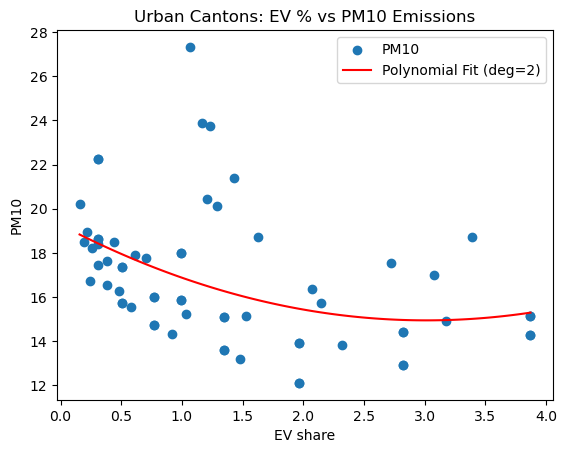

In [24]:
# 2. Define X and y
X = df_vaud[['EVshare']]
y = df_vaud[['pollution']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# 7. Plot the curve
x_range = np.linspace(X['EVshare'].min(), X['EVshare'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='PM10')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('EV share')
plt.ylabel('PM10')
plt.title('Urban Cantons: EV % vs PM10 Emissions')
plt.legend()
plt.show()

In [25]:
# Define features and target
X = df_vaud[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
y = df_vaud[['pollution']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 6.590456111474634
MAE: 2.2140200393231924


In [26]:
X = df_vaud[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
X_const = sm.add_constant(X)
y = df_vaud['pollution']

model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary())

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:              pollution   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     6.448
Date:                Wed, 21 May 2025   Prob (F-statistic):           7.91e-05
Time:                        18:36:18   Log-Likelihood:                -153.35
No. Observations:                  64   AIC:                             318.7
Df Residuals:                      58   BIC:                             331.7
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.5648     14.078      0.395      0.6

## Cantons Suburban

In [27]:
df_lucerne = df[df['Canton'].isin(['BL', 'GE'])]

In [28]:
'''# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)
switzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')

# List of cantons you have data for
cantons_with_data = ['Basel-Landschaft', 'Genève']


print(switzerland_map.columns, switzerland_map.NAME.unique())
display(switzerland_map.head())
print(cantons_with_data)

# Highlight the cantons
switzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
switzerland_map.plot(ax=ax, color='white', edgecolor='black')
switzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')
ax.axis('off')  # Hide the axis
# Add legend and title
#plt.legend()
#plt.title('Available Cantons')
plt.show()'''

"# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)\nswitzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')\n\n# List of cantons you have data for\ncantons_with_data = ['Basel-Landschaft', 'Genève']\n\n\nprint(switzerland_map.columns, switzerland_map.NAME.unique())\ndisplay(switzerland_map.head())\nprint(cantons_with_data)\n\n# Highlight the cantons\nswitzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)\n\n# Plot the map\nfig, ax = plt.subplots(figsize=(10, 8))\nswitzerland_map.plot(ax=ax, color='white', edgecolor='black')\nswitzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')\nax.axis('off')  # Hide the axis\n# Add legend and title\n#plt.legend()\n#plt.title('Available Cantons')\nplt.show()"

MSE: 2.888858312687512
MAE: 1.579640962690144
R² Score: 0.17811322511795358


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


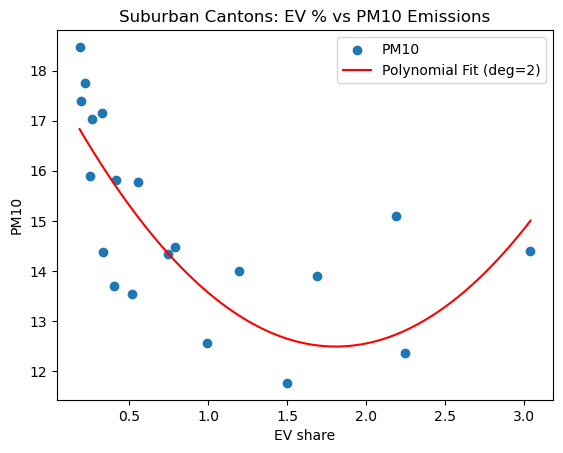

In [29]:
X = df_lucerne[['EVshare']]
y = df_lucerne[['pollution']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
x_range = np.linspace(X['EVshare'].min(), X['EVshare'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='PM10')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('EV share')
plt.ylabel('PM10')
plt.title('Suburban Cantons: EV % vs PM10 Emissions')
plt.legend()
plt.show()

In [30]:
# Define features and target
X = df_lucerne[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
y = df_lucerne[['pollution']]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 11.057463307225786
MAE: 2.9264783172259383


In [31]:
'''# Define features and target
X = df_lucerne[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
y = df_lucerne[['pollution']]

# Train-test split
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))'''

'# Define features and target\nX = df_lucerne[[\'EVshare\', \'logpop\', \'temp\', \'precip\', \'GDP\']]\ny = df_lucerne[[\'pollution\']]\n\n# Train-test split\npoly = PolynomialFeatures(degree=2)\nX_poly = poly.fit_transform(X)\n\n# 4. Split the data\nX_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)\n\n# 5. Fit the model\nmodel = LinearRegression()\nmodel.fit(X_train, y_train)\n\n# 6. Predict and evaluate\ny_pred = model.predict(X_test)\n\nprint("MSE:", mean_squared_error(y_test, y_pred))\nprint("MAE:", mean_absolute_error(y_test, y_pred))\nprint("R² Score:", r2_score(y_test, y_pred))'

In [32]:
X = df_lucerne[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
X_const = sm.add_constant(X)
y = df_lucerne['pollution']

model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary())

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:              pollution   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1.176
Date:                Wed, 21 May 2025   Prob (F-statistic):              0.369
Time:                        18:36:19   Log-Likelihood:                -32.397
No. Observations:                  20   AIC:                             76.79
Df Residuals:                      14   BIC:                             82.77
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.8808     21.866     -1.184      0.2

# Canton Ruraux

In [33]:
df_geneve = df[df['Canton'].isin(['LU', 'NE', 'TG', 'VS'])]

In [34]:
'''# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)
switzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')

# List of cantons you have data for
cantons_with_data = ['Luzern', 'Neuchâtel', 'Thurgau', 'Valais']


print(switzerland_map.columns, switzerland_map.NAME.unique())
display(switzerland_map.head())
print(cantons_with_data)

# Highlight the cantons
switzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))
switzerland_map.plot(ax=ax, color='white', edgecolor='black')
switzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')
ax.axis('off')  # Hide the axis
# Add legend and title
#plt.legend()
#plt.title('Available Cantons')
plt.show()'''

"# Load a shapefile of Switzerland (you can find shapefiles online, e.g., from Natural Earth or Swiss government sources)\nswitzerland_map = gpd.read_file('C:/Users/simon/OneDrive/Bureau/Shapefile/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp')\n\n# List of cantons you have data for\ncantons_with_data = ['Luzern', 'Neuchâtel', 'Thurgau', 'Valais']\n\n\nprint(switzerland_map.columns, switzerland_map.NAME.unique())\ndisplay(switzerland_map.head())\nprint(cantons_with_data)\n\n# Highlight the cantons\nswitzerland_map['highlight'] = switzerland_map['NAME'].apply(lambda x: x in cantons_with_data)\n\n# Plot the map\nfig, ax = plt.subplots(figsize=(10, 8))\nswitzerland_map.plot(ax=ax, color='white', edgecolor='black')\nswitzerland_map[switzerland_map['highlight']].plot(ax=ax, color='red', edgecolor='black', label='Highlighted Cantons')\nax.axis('off')  # Hide the axis\n# Add legend and title\n#plt.legend()\n#plt.title('Available Cantons')\nplt.show()"

MSE: 13.28918747614274
MAE: 3.397269128058392
R² Score: -0.05241598514878376


c:\Users\simon\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


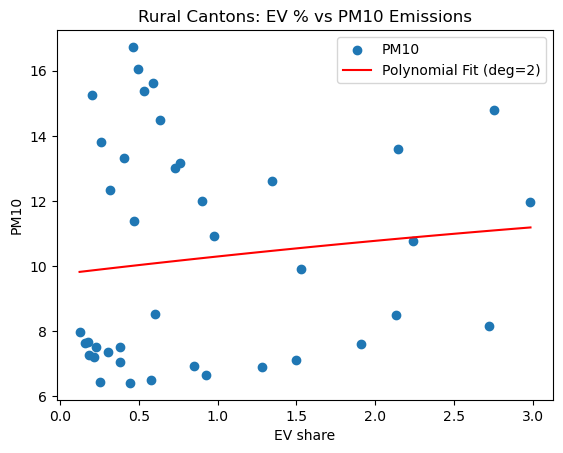

In [35]:
# 2. Define X and y
X = df_geneve[['EVshare']]
y = df_geneve[['pollution']]

# 3. Transform features into polynomial (degree = 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=0)

# 5. Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

# 7. Plot the curve
x_range = np.linspace(X['EVshare'].min(), X['EVshare'].max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)

plt.scatter(X, y, label='PM10')
plt.plot(x_range, y_range_pred, color='red', label='Polynomial Fit (deg=2)')
plt.xlabel('EV share')
plt.ylabel('PM10')
plt.title('Rural Cantons: EV % vs PM10 Emissions')
plt.legend()
plt.show()



In [36]:
# Define features and target
X = df_geneve[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
y = df_geneve[['pollution']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

MSE: 1.9889981218867243
MAE: 1.1948549424404562


In [37]:
X = df_geneve[['EVshare', 'logpop', 'temp', 'precip', 'GDP']]
X_const = sm.add_constant(X)
y = df_geneve['pollution']

model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary())

vif_df = pd.DataFrame()
vif_df['Variable'] = X_const.columns
vif_df['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_df)

                            OLS Regression Results                            
Dep. Variable:              pollution   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     26.71
Date:                Wed, 21 May 2025   Prob (F-statistic):           7.15e-11
Time:                        18:36:19   Log-Likelihood:                -79.188
No. Observations:                  40   AIC:                             170.4
Df Residuals:                      34   BIC:                             180.5
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2897     15.223     -0.282      0.7

# Consumption-based Emissions

In [38]:
consumed_co2 = pd.read_csv("https://ourworldindata.org/grapher/production-vs-consumption-co2-emissions.csv?v=1&csvType=filtered&useColumnShortNames=true&time=1988..latest&country=~CHE", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'}) 

In [39]:
consumed_co2.head(2)

,Entity,Code,Year,emissions_total,consumption_emissions
0,Switzerland,CHE,1988,40636268,NaN
1,Switzerland,CHE,1989,39388684,NaN


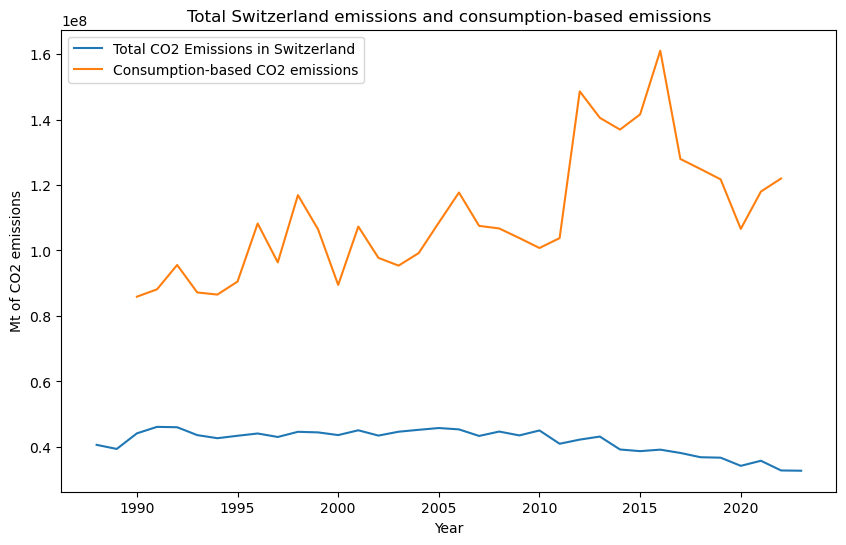

In [40]:
plt.figure(figsize=(10,6))
plt.plot(consumed_co2['Year'], consumed_co2['emissions_total'], label='Total CO2 Emissions in Switzerland')
plt.plot(consumed_co2['Year'], consumed_co2['consumption_emissions'], label='Consumption-based CO2 emissions')

plt.xlabel('Year')
plt.ylabel('Mt of CO2 emissions')

plt.title('Total Switzerland emissions and consumption-based emissions')
plt.legend()
plt.show()